### В данном ноутбуке решается задача анализа тональности текстовых отзывов на основе набора данных Brazilian E-Commerce Public Dataset by Olist (Order Reviews Dataset). 
Целью работы является определение эмоциональной окраски отзыва по его тексту с использованием методов обработки естественного языка и машинного обучения.

В ходе работы выполняется предобработка текстовых данных, формирование целевой переменной на основе пользовательских оценок, обучение модели классификации и оценка её качества.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### Ссылка для скачивания датасета
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_reviews_dataset.csv

In [5]:
path = "../Datasets/olist_order_reviews_dataset.csv.zip"

df = pd.read_csv(path, compression='zip', nrows=100000)

print(df.head())
print(df.shape)


                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3           

### Проверяем наличие нулевых строк в каждом столбце

In [6]:
print(df.shape)
print(df.columns)

print(df.isnull().sum())


(99224, 7)
Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


### Создаем новый датафрейм без нулевых строк

In [7]:
df_text = df.dropna(subset=['review_comment_message', 'review_comment_title'], how='all').copy()

df_text.head()


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01


### Визуализируем распределение оценок отзывов

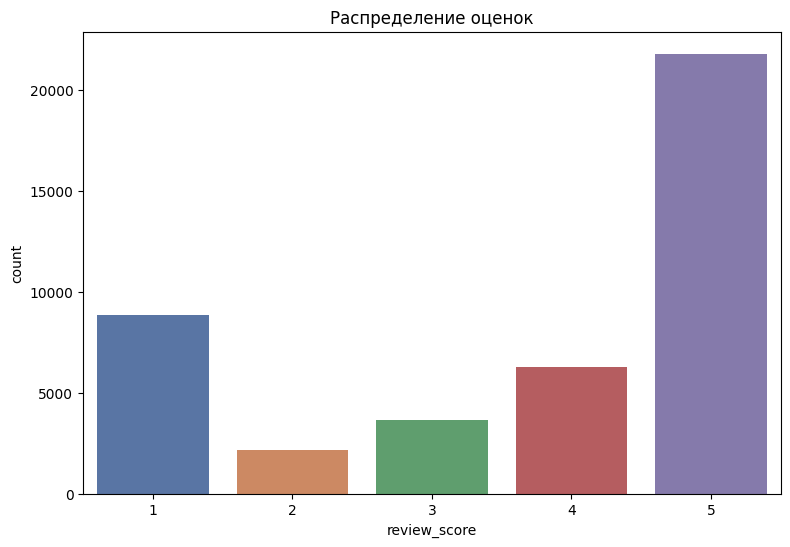

In [8]:
plt.figure(figsize=(9,6))
sns.countplot(x='review_score', data=df_text, hue='review_score', palette='deep', legend=False)
plt.title('Распределение оценок')
plt.show()



### Объединяем строки с отзывами в одну общую

In [9]:
df_text['text'] = df_text['review_comment_title'].fillna('') + ' ' + df_text['review_comment_message'].fillna('')
df_text['text'] = df_text['text'].str.strip()


In [10]:
print(df_text.iloc[[18]]['text'])
df_text.head(15)

43    Entrega perfeita Muito bom. muito cheiroso.
Name: text, dtype: object


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,text
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela I...
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,"Mas um pouco ,travando...pelo valor ta Boa."
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,"Super recomendo Vendedor confiável, produto ok..."
16,9314d6f9799f5bfba510cc7bcd468c01,0dacf04c5ad59fd5a0cc1faa07c34e39,2,NaN,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2018-01-18 00:00:00,2018-01-20 21:25:45,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E..."
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,Não chegou meu produto Péssimo
22,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25,Ótimo Loja nota 10
24,0e0190b9db53b689b285d3f3916f8441,79832b7cb59ac6f887088ffd686e1d5e,5,NaN,obrigado pela atençao amim dispensada,2017-12-01 00:00:00,2017-12-09 22:58:58,obrigado pela atençao amim dispensada
27,fe3db7c069d694bab50cc43463f91608,2ca73e2ff9e3a186ad1e1ffb9b1d9c10,5,NaN,A compra foi realizada facilmente.\r\nA entreg...,2018-03-23 00:00:00,2018-04-01 00:27:51,A compra foi realizada facilmente.\r\nA entreg...


### В датасете отзывы написаны на разных языках
Поэтому, чтобы определить язык, можно использовать библиотеку langdetect

In [11]:
# !pip install langdetect

In [12]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return "error"


### Получили информацию о количествах отзывов на каждом из языков

In [13]:
df_text['lang'] = df_text['text'].apply(detect_lang)

print(df_text['lang'].value_counts())


lang
pt       37038
it        1512
es         803
ro         471
sk         463
lt         399
en         334
de         319
error      262
hr         176
ca         148
af         104
sl          98
fi          81
hu          62
so          59
nl          44
fr          42
sv          35
sw          33
id          32
vi          31
tl          22
pl          22
et          20
no          16
lv          16
da          16
cy          15
tr          15
sq          10
cs           8
Name: count, dtype: int64


### Будем обучать модель на португальских отзывах, так как их больше

In [14]:
df_text = df_text[df_text['lang'] == 'pt'].copy()

print(df_text.shape)
print(df_text[['text', 'lang']].head())

(37038, 9)
                                                 text lang
3               Recebi bem antes do prazo estipulado.   pt
4   Parabéns lojas lannister adorei comprar pela I...   pt
9   recomendo aparelho eficiente. no site a marca ...   pt
12        Mas um pouco ,travando...pelo valor ta Boa.   pt
15  Super recomendo Vendedor confiável, produto ok...   pt


### Будем использовать токенайзер spacy

In [15]:
# !pip install spacy
# !python -m spacy download pt_core_news_sm

In [ ]:
import spacy

nlp = spacy.load('pt_core_news_sm')

In [18]:
from nltk.corpus import stopwords
import nltk
stop_words_pt = {
    'a', 'à', 'agora', 'ainda', 'alguém', 'algum', 'alguma', 'algumas',
    'alguns', 'ali', 'ambos', 'antes', 'ao', 'aos', 'apenas', 'após',
    'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até',
    'através', 'cada', 'catorze', 'cedo', 'cento', 'certamente',
    'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como',
    'conselho', 'contra', 'contudo', 'custa', 'da', 'daquela',
    'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo',
    'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois',
    'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas',
    'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá',
    'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia',
    'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'do', 'dois',
    'dos', 'doze', 'duas', 'e', 'ela', 'elas', 'ele', 'eles', 'em',
    'embora', 'enquanto', 'entre', 'era', 'essa', 'essas', 'esse',
    'esses', 'esta', 'está', 'estamos', 'estão', 'estas', 'estava',
    'estavam', 'este', 'esteja', 'estejam', 'estejamos', 'estes',
    'esteve', 'estive', 'estivemos', 'estiver', 'estivera',
    'estiveram', 'estiverem', 'estivermos', 'estivesse',
    'estivessem', 'estivéramos', 'estivéssemos', 'estou', 'etc',
    'eu', 'fará', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazer',
    'fazes', 'feita', 'feitas', 'feito', 'feitos', 'foi', 'fomos',
    'for', 'fora', 'foram', 'forem', 'forma', 'formos', 'fosse',
    'fossem', 'fui', 'geral', 'grande', 'grandes', 'há', 'isso',
    'isto', 'já', 'la', 'lá', 'lhe', 'lhes', 'lo', 'logo', 'mais',
    'mal', 'mas', 'me', 'mediante', 'meio', 'menor', 'menos', 'mesma',
    'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'minha', 'minhas',
    'momento', 'muito', 'muitos', 'na', 'nada', 'não', 'naquela',
    'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum',
    'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste',
    'nestes', 'ninguém', 'no', 'nos', 'nós', 'nossa', 'nossas',
    'nosso', 'nossos', 'nova', 'novas', 'novo', 'novos', 'num',
    'numa', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava',
    'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra',
    'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir',
    'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'per', 'perante',
    'perto', 'pode', 'podem', 'podendo', 'poder', 'poderá',
    'poderão', 'podia', 'podiam', 'pois', 'por', 'porque', 'porquê',
    'posição', 'possível', 'possivelmente', 'posso', 'pouca',
    'poucas', 'pouco', 'poucos', 'primeira', 'primeiras',
    'primeiro', 'primeiros', 'própria', 'próprias', 'próprio',
    'próprios', 'próxima', 'próximas', 'próximo', 'próximos',
    'pude', 'quais', 'qual', 'qualquer', 'quando', 'quanto',
    'quarta', 'quarto', 'quatro', 'que', 'quem', 'quer', 'quereis',
    'querem', 'queremas', 'queres', 'quero', 'questão', 'quinta',
    'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se',
    'segunda', 'segundo', 'sei', 'seis', 'sem', 'sempre', 'sendo',
    'ser', 'será', 'serão', 'seu', 'seus', 'sexta', 'sexto', 'sim',
    'sistema', 'sob', 'sobre', 'sois', 'somente', 'somos', 'sou',
    'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco', 'te',
    'tem', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham',
    'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira',
    'terceiro', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha',
    'tinham', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram',
    'tivermos', 'tivesse', 'tivessem', 'toda', 'todas', 'todo',
    'todos', 'trabalhar', 'três', 'treze', 'tu', 'tua', 'tuas',
    'tudo', 'última', 'últimas', 'último', 'últimos', 'um', 'uma',
    'umas', 'uns', 'usa', 'usar', 'vai', 'vais', 'valor', 'veja',
    'vem', 'vens', 'ver', 'verdade', 'vez', 'vezes', 'viagem',
    'vindo', 'vinte', 'você', 'vocês', 'vos', 'vós'
}


### Переведем текст в нижний регистр, удалим пунктуацию и цифры

In [19]:
import re
import string

def preprocess(text):
    if pd.isnull(text):
        return []

    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\d+', '', text)

    doc = nlp(text)

    tokens = [token.text for token in doc if not token.is_space and token.text not in stop_words_pt]
    tokens = [t for t in tokens if t.strip()]
    return tokens

In [20]:
df_text['tokens'] = df_text['text'].apply(preprocess)
df_text[['text', 'tokens']].head()


,text,tokens
3,Recebi bem antes do prazo estipulado.,"[recebi, bem, prazo, estipulado]"
4,Parabéns lojas lannister adorei comprar pela I...,"[parabéns, lojas, lannister, adorei, comprar, ..."
9,recomendo aparelho eficiente. no site a marca ...,"[recomendo, aparelho, eficiente, site, marca, ..."
12,"Mas um pouco ,travando...pelo valor ta Boa.","[travando, ta, boa]"
15,"Super recomendo Vendedor confiável, produto ok...","[super, recomendo, vendedor, confiável, produt..."


In [21]:
df_text['clean_text'] = df_text['tokens'].apply(lambda x: ' '.join(x))
df_text.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,text,lang,tokens,clean_text
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.,pt,"[recebi, bem, prazo, estipulado]",recebi bem prazo estipulado
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela I...,pt,"[parabéns, lojas, lannister, adorei, comprar, ...",parabéns lojas lannister adorei comprar intern...
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,recomendo aparelho eficiente. no site a marca ...,pt,"[recomendo, aparelho, eficiente, site, marca, ...",recomendo aparelho eficiente site marca aparel...
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,"Mas um pouco ,travando...pelo valor ta Boa.",pt,"[travando, ta, boa]",travando ta boa
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,"Super recomendo Vendedor confiável, produto ok...",pt,"[super, recomendo, vendedor, confiável, produt...",super recomendo vendedor confiável produto ok ...


### Сделаем из чисел категориальный столбец label

In [22]:
def get_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'
df_text['label'] = df_text['review_score'].apply(get_sentiment)

In [23]:
df_text.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,text,lang,tokens,clean_text,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.,pt,"[recebi, bem, prazo, estipulado]",recebi bem prazo estipulado,positive
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela I...,pt,"[parabéns, lojas, lannister, adorei, comprar, ...",parabéns lojas lannister adorei comprar intern...,positive
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,recomendo aparelho eficiente. no site a marca ...,pt,"[recomendo, aparelho, eficiente, site, marca, ...",recomendo aparelho eficiente site marca aparel...,positive
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,"Mas um pouco ,travando...pelo valor ta Boa.",pt,"[travando, ta, boa]",travando ta boa,positive
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,"Super recomendo Vendedor confiável, produto ok...",pt,"[super, recomendo, vendedor, confiável, produt...",super recomendo vendedor confiável produto ok ...,positive


In [24]:
print(df_text['label'].value_counts())
df_text[['text', 'clean_text', 'review_score', 'label']].head()

label
positive    23168
negative    10593
neutral      3277
Name: count, dtype: int64


,text,clean_text,review_score,label
3,Recebi bem antes do prazo estipulado.,recebi bem prazo estipulado,5,positive
4,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...,5,positive
9,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente site marca aparel...,4,positive
12,"Mas um pouco ,travando...pelo valor ta Boa.",travando ta boa,4,positive
15,"Super recomendo Vendedor confiável, produto ok...",super recomendo vendedor confiável produto ok ...,5,positive


### Подготовим текст для FastText

In [25]:
df_text['clean_text'].to_csv(
    "FastText_corpus.txt",
    index=False,
    header=False,
    encoding="utf-8"
)

In [26]:
# !pip install fasttext
import fasttext

In [27]:
model = fasttext.train_unsupervised(
    input="FastText_corpus.txt",
    model="skipgram",
    dim=100,
    epoch=30,
    lr=0.05,
    ws=5,
    minn=3,
    maxn=6,
    minCount=3,
    neg=10,
    bucket=2000000,
    thread=4
)

### Получим эмбеддинги предложений

In [28]:
X = np.array([model.get_sentence_vector(text) for text in df_text['clean_text']])
y = df_text['label'].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (37038, 100)
y shape: (37038,)


### Поделим выборку на train и test

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

## LogisticRegression

In [31]:
clf = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    class_weight='balanced'  # если классы несбалансированы
)
clf.fit(X_train, y_train)

c:\Users\User\OneDrive\Рабочий стол\Kaggle\PyTorch\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [32]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7626889848812095
              precision    recall  f1-score   support

    negative       0.79      0.75      0.77      2119
     neutral       0.23      0.52      0.32       655
    positive       0.95      0.80      0.87      4634

    accuracy                           0.76      7408
   macro avg       0.66      0.69      0.65      7408
weighted avg       0.84      0.76      0.79      7408



### По Confusion Matrix видно, что модель хорошо определяет positive и negative, но очень плохо neutral

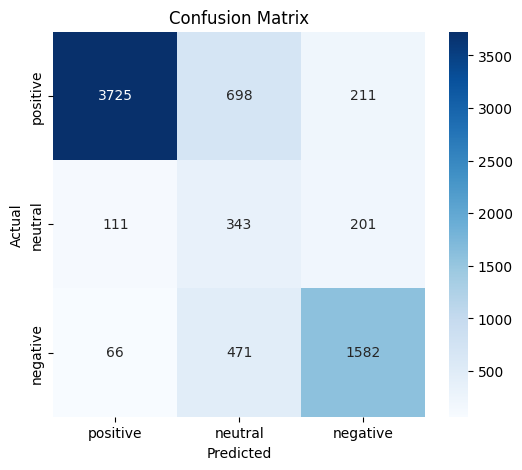

In [33]:
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
cm_df = pd.DataFrame(cm, index=["positive", "neutral", "negative"], columns=["positive", "neutral", "negative"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

## CatBoost

In [34]:
# !pip install catboost
from catboost import CatBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

### Посчитаем веса каждого класса

In [35]:
from collections import Counter
# считаем количество каждого класса
counter = Counter(y_train)
total = sum(counter.values())

# делаем так, чтобы редкие классы имели больший вес
class_weights = {cls: total/count for cls, count in counter.items()}
print(class_weights)


{'positive': 1.5986835005935038, 'negative': 3.4965777672881755, 'neutral': 11.300533943554539}


In [36]:
from catboost import CatBoostClassifier
clf_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=50,
    class_weights=class_weights
  )
clf_cb.fit(X_train, y_train)


0:	learn: 1.0550823	total: 206ms	remaining: 1m 42s
50:	learn: 0.7130170	total: 3.81s	remaining: 33.5s
100:	learn: 0.6640049	total: 6.63s	remaining: 26.2s
150:	learn: 0.6229465	total: 9.21s	remaining: 21.3s
200:	learn: 0.5880111	total: 11.9s	remaining: 17.6s
250:	learn: 0.5585231	total: 14.4s	remaining: 14.3s
300:	learn: 0.5324751	total: 16.9s	remaining: 11.2s
350:	learn: 0.5083262	total: 19.5s	remaining: 8.3s
400:	learn: 0.4866343	total: 22.1s	remaining: 5.45s
450:	learn: 0.4668239	total: 24.7s	remaining: 2.68s
499:	learn: 0.4496407	total: 27.2s	remaining: 0us


In [37]:
from sklearn.metrics import classification_report, accuracy_score
y_pred_cb = clf_cb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_cb))
print(classification_report(y_test, y_pred_cb))


Accuracy: 0.7975161987041036
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80      2119
     neutral       0.25      0.40      0.31       655
    positive       0.95      0.84      0.89      4634

    accuracy                           0.80      7408
   macro avg       0.66      0.69      0.67      7408
weighted avg       0.84      0.80      0.81      7408



### CatBoost дает чуть лучшие предсказания на positive и negative, но все также плохо на neutral

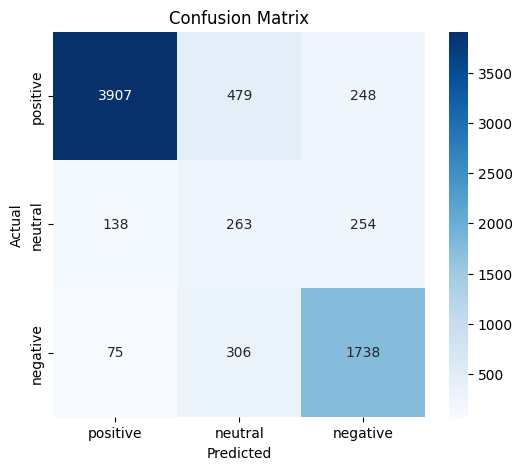

In [38]:
cm = confusion_matrix(y_test, y_pred_cb, labels=["positive", "neutral", "negative"])
cm_df = pd.DataFrame(cm, index=["positive", "neutral", "negative"], columns=["positive", "neutral", "negative"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

## BERT
### Используем предобученную архитектуру BERT для протугальского языка

In [39]:
from transformers import AutoTokenizer, AutoModel
import torch

# Используем BERT для португальского языка
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

text = "produto chegou quebrado e atrasado"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




In [40]:
tokenized_text = tokenizer(
    text,
    return_tensors="pt",
)

In [41]:
with torch.no_grad():
    output=model(**tokenized_text)
print(tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0]))
output.last_hidden_state[:,0,:]

['[CLS]', 'produto', 'chegou', 'quebrado', 'e', 'atras', '##ado', '[SEP]']


tensor([[ 4.5702e-01, -6.2364e-01,  1.0013e-02,  1.2401e-01,  7.8721e-01,
          3.0232e-01,  3.9354e-01, -3.6576e-01, -3.0270e-02,  6.1105e-01,
         -5.2398e-02,  2.9061e-01,  3.9804e-01, -3.6625e-01,  2.2622e-01,
          1.8029e-02,  1.4863e-01,  4.6926e-01,  1.8553e-01,  1.8351e-01,
         -3.9382e-01,  1.6388e-01,  4.7122e-01,  2.0224e-01,  1.6736e-01,
          7.1913e-02, -4.2343e-01,  9.1990e-01,  2.2860e-01, -2.3010e-01,
         -1.1344e-02,  6.1944e-01,  3.1783e-01,  2.0088e-01, -2.5655e-01,
         -2.8439e-03, -3.5343e-01, -8.0557e-02,  6.7242e-02, -1.2374e-01,
         -1.0492e-01, -6.8466e-02,  9.8184e-02, -1.8650e-02, -1.0885e-03,
         -2.7059e-01, -1.5072e-01, -1.1924e-01, -4.2381e-01, -2.6262e-01,
         -1.6627e-01, -6.0480e-02,  2.4314e-01,  4.0692e-02,  6.4749e-01,
          6.4241e-02,  9.4705e-02, -1.9396e-01,  9.9771e-02, -2.0598e-01,
          5.1432e-02,  1.4517e-01,  2.9716e-01,  3.3200e-02, -5.2947e-01,
          2.6640e-02,  1.9001e-01, -4.

In [42]:
tokenized_text=tokenizer(text)

for key, values in tokenized_text.items():
    values_type =type(values).__name__
    item_type = type(values[0]).__name__
    values_sample =f"[{', '.join(str(value) for value in values[:5])}, ...]"
    print(f"{key}: {values_type}[{item_type}], length {len(values)}: {values_sample}")

input_ids: list[int], length 8: [101, 3576, 2080, 19797, 122, ...]
token_type_ids: list[int], length 8: [0, 0, 0, 0, 0, ...]
attention_mask: list[int], length 8: [1, 1, 1, 1, 1, ...]


In [43]:
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'])} ")
print(f"Decoded seuence {tokenizer.decode(tokenized_text['input_ids'])}")

Tokens: ['[CLS]', 'produto', 'chegou', 'quebrado', 'e', 'atras', '##ado', '[SEP]'] 
Decoded seuence [CLS] produto chegou quebrado e atrasado [SEP]


In [44]:
tokenized_texts=tokenizer(df_text['clean_text'].tolist())

In [45]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [46]:
import numpy as np
model.to(device)
model.eval()
batch_size=32
features = []
labels=df_text['label'].tolist()
from torch.nn.utils.rnn import pad_sequence
with torch.no_grad():
    for i in range(0, len(tokenized_texts['input_ids']), batch_size):

        texts_batch =tokenized_texts["input_ids"][i : i + batch_size]
        texts_batch_tensor=[torch.tensor(text) for text in texts_batch]
        texts_padded = pad_sequence(texts_batch_tensor, batch_first=False, padding_value=1).to(device)
        # print(texts_padded.shape)

        masks_batch = tokenized_texts["attention_mask"][i : i + batch_size]
        masks_batch_tensor=[torch.tensor(text) for text in masks_batch]
        maskes_padded = pad_sequence(masks_batch_tensor,batch_first=False, padding_value=0).to(device)

        texts_padded=texts_padded.permute(1,0)
        maskes_padded=maskes_padded.permute(1,0)

        output = model(texts_padded, maskes_padded)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy() # Берем [все батчи, вектор cls, длина эмбеддинга]
        features.append(batch_features)


features = np.concatenate(features, axis=0)

features.shape

c:\Users\User\OneDrive\Рабочий стол\Kaggle\PyTorch\venv\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


(37038, 768)

In [47]:
features[0]

array([ 4.20453876e-01, -4.67074603e-01,  1.63697466e-01, -1.16444327e-01,
        7.84269989e-01,  4.80550915e-01,  2.42708754e-02, -1.79075152e-02,
        7.50932470e-02,  3.94015461e-01, -5.86064458e-01,  3.89749587e-01,
        2.39622101e-01, -5.56903183e-01,  4.74608690e-01, -4.68034834e-01,
        6.19824901e-02,  1.97448865e-01,  4.77440864e-01,  5.76595008e-01,
       -3.88876706e-01,  2.47666538e-01,  4.13517952e-01,  2.68054098e-01,
        2.12036148e-01,  3.88788432e-02, -2.56365836e-01,  4.89369631e-01,
        2.20925555e-01, -4.67326343e-01,  4.63424146e-01,  6.03228986e-01,
       -1.52447343e-01,  3.95172596e-01, -5.28369844e-01,  3.39935645e-02,
       -2.30597898e-01, -5.25630638e-02, -2.93584913e-01, -2.85373360e-01,
        2.84883201e-01,  1.66575052e-02,  1.74333099e-02, -3.90228689e-01,
       -3.11512668e-02, -1.65309682e-02, -1.22815527e-01, -4.07393545e-01,
       -5.49770109e-02, -2.37536982e-01,  6.61118999e-02, -5.34030832e-02,
        1.01855256e-01, -

## LogisticRegression

In [48]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [49]:
import warnings
from sklearn.linear_model import LogisticRegression

warnings.simplefilter('ignore')
lr_clf = LogisticRegression().fit(train_features, train_labels)

In [50]:
lr_clf.score(test_features, test_labels)

0.8163066954643629

In [51]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7627


In [53]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

    negative     0.7934    0.7466    0.7693      2119
     neutral     0.2269    0.5237    0.3166       655
    positive     0.9546    0.8038    0.8728      4634

    accuracy                         0.7627      7408
   macro avg     0.6583    0.6914    0.6529      7408
weighted avg     0.8442    0.7627    0.7940      7408



### Результаты почти ничем не отличается от FastText + LogisticRegression
Результаты схожи скорее всего, потому что корпус относительно небольшой и BERT не раскрыл свой потенциал

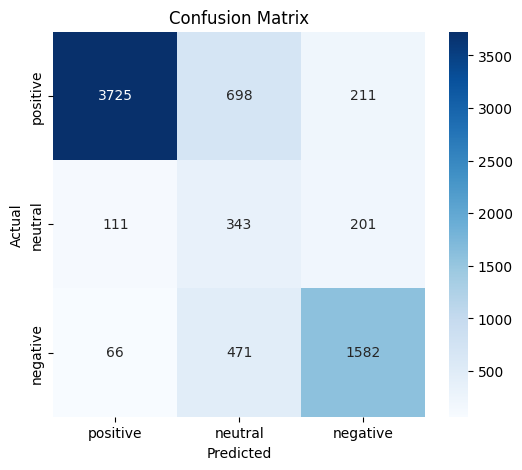

In [54]:
cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
cm_df = pd.DataFrame(cm, index=["positive", "neutral", "negative"], columns=["positive", "neutral", "negative"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

## CatBoost

In [55]:
from catboost import CatBoostRegressor

clf_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    class_weights=class_weights,
    verbose=50,
    random_seed=42
)
clf_cb.fit(X_train, y_train)

0:	learn: 1.0550495	total: 77.3ms	remaining: 38.6s
50:	learn: 0.7130155	total: 4.17s	remaining: 36.8s
100:	learn: 0.6627783	total: 7.75s	remaining: 30.6s
150:	learn: 0.6240806	total: 11s	remaining: 25.5s
200:	learn: 0.5903820	total: 13.9s	remaining: 20.7s
250:	learn: 0.5615283	total: 16.8s	remaining: 16.7s
300:	learn: 0.5349161	total: 19.7s	remaining: 13s
350:	learn: 0.5121019	total: 22.5s	remaining: 9.56s
400:	learn: 0.4918056	total: 25.3s	remaining: 6.24s
450:	learn: 0.4721268	total: 28s	remaining: 3.04s
499:	learn: 0.4539346	total: 30.6s	remaining: 0us


Accuracy: 0.796841252699784
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80      2119
     neutral       0.25      0.39      0.30       655
    positive       0.95      0.84      0.89      4634

    accuracy                           0.80      7408
   macro avg       0.66      0.69      0.66      7408
weighted avg       0.84      0.80      0.81      7408



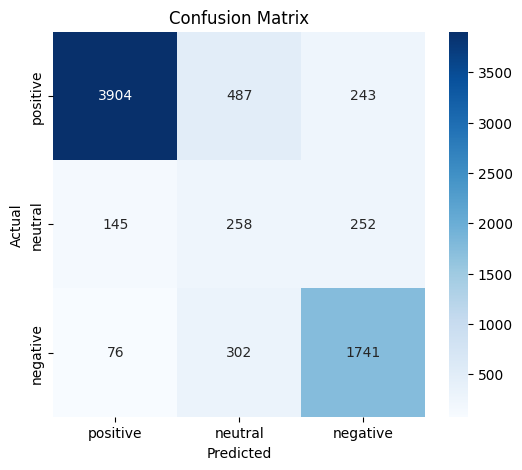

In [56]:
y_pred = clf_cb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
cm_df = pd.DataFrame(cm, index=["positive", "neutral", "negative"], columns=["positive", "neutral", "negative"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

### BERT + CatBoost имеет почти теже самые результаты, что и FastText + CatBoost
Что ткаже связано с относительно небольшим корпусом

Можно сделать вывод, что CatBoost справился немного лучше, чем логистическая регрессия